# Data Modeling

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [219]:
# Load in cleaned data
train = pd.read_csv('../datasets/train_clean_final.csv')
test = pd.read_csv('../datasets/test_clean_final.csv')
pd.set_option('display.max_columns', None)
style.use('seaborn-whitegrid')

In [220]:
# Split data
X = train.drop(columns=['logsaleprice','saleprice'])
y = train['logsaleprice']

In [221]:
# Generate Train Test Split with default 75%:25% as there are sufficient values in the dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [222]:
# Scale data for Ridge and Lasso regressions.
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [223]:
print(f'Z_train shape is: {Z_train.shape}')
print(f'y_train shape is: {y_train.shape}')
print(f'Z_test shape is: {Z_test.shape}')
print(f'y_test shape is: {y_test.shape}')

Z_train shape is: (1538, 296)
y_train shape is: (1538,)
Z_test shape is: (513, 296)
y_test shape is: (513,)


In [224]:
# Create function to print scores
def scores(model, A_train, b_train, A_test, b_test):
    print(f'Train Score: {model.score(A_train, b_train)}.')
    print(f'Test Score: {model.score(A_test, b_test)}.')
    print(f'Cross Validation Score: {cross_val_score(model, A_train, b_train, cv=5).mean()}.')
    print(f'RMSE on Test: {np.sqrt(mean_squared_error(np.exp(b_test), np.exp(model.predict(A_test))))}.')
    print(f'MAE on Test: {mean_absolute_error(np.exp(b_test), np.exp(model.predict(A_test)))}.')


## Method A: Choosing An Appropriate Model

### Model 1: Dummy Regressor Baseline

In [225]:
# The baseline null model (i.e. predicting the mean log sale price) is unable to explain any of the variation in the target as evidenced by the R2 of 0. 
dr = DummyRegressor()
dr.fit(X_train, y_train)
scores(dr, X_train, y_train, X_test, y_test)

Train Score: 0.0.
Test Score: -0.00022039068907830917.
Cross Validation Score: -0.001462253802185165.
RMSE on Test: 80011.24799265602.
MAE on Test: 57584.932746008606.


### Model 2: OLS

In [226]:
# The OLS has done much better. However as expected, train score is much higher than test score and cross validation score which indicates overfitting.
lr = LinearRegression()
lr.fit(X_train, y_train)
scores(lr, X_train, y_train, X_test, y_test)

Train Score: 0.9554445602432966.
Test Score: 0.8792463622236112.
Cross Validation Score: 0.733612660917584.
RMSE on Test: 23966.878219720784.
MAE on Test: 15342.59415552821.


### Model 3: RidgeCV

In [227]:
r_alphas = np.logspace(0,5,100)
ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
ridge_cv = ridge_model.fit(Z_train, y_train)

In [228]:
print(f'Optimal alpha: {ridge_cv.alpha_}')
scores(ridge_cv, Z_train, y_train, Z_test, y_test)

Optimal alpha: 673.4150657750821
Train Score: 0.9236657144457547.
Test Score: 0.8718046685695432.
Cross Validation Score: 0.8586915505922074.
RMSE on Test: 24961.772074979825.
MAE on Test: 16757.580596638767.


### Model 4: LassoCV

In [229]:
l_alphas = np.logspace(-3,0,100)
lasso_model = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)
lasso_cv = lasso_model.fit(Z_train, y_train)

In [230]:
print(f'Optimal alpha: {lasso_cv.alpha_}')
scores(lasso_cv, Z_train, y_train, Z_test, y_test)

Optimal alpha: 0.005336699231206312
Train Score: 0.9189048007105023.
Test Score: 0.8872686334929739.
Cross Validation Score: 0.8442141116111849.
RMSE on Test: 22838.434055761816.
MAE on Test: 15259.094484493253.


### Model 5: ElasticNetCV

In [231]:
enet_alphas = np.linspace(0.01, 1.0, 100)
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=[0.01, 0.05, 0.07, 0.09, 0.95, 0.99], cv=5)
enet_cv = enet_model.fit(Z_train, y_train)

In [232]:
print(f'Optimal alpha: {enet_cv.alpha_}')
print(f'Optimal l1_ratio: {enet_cv.l1_ratio_}')
scores(enet_cv, Z_train, y_train, Z_test, y_test)

Optimal alpha: 0.29000000000000004
Optimal l1_ratio: 0.01
Train Score: 0.9188045395373089.
Test Score: 0.8782850098695391.
Cross Validation Score: 0.8594128328353999.
RMSE on Test: 24411.67182616721.
MAE on Test: 16283.35097280616.


The best performing model is Lasso with the highest train and test score and closest difference between the train score and test score, indicating a low bias and a low variance. This is not unexpected given the large number of variables and likely high multicollinearity, as Lasso can reduce the regression coefficients to 0, which will reduce variance. 

The fact that the optimal L1 Ratio for ElasticNetCV is 0.01 also lends support that Lasso is the better model in this case compared to Ridge.

While the cross validation score is higher for ElasticNetCV, I am less inclined to use this metric, as the cross validation scores may be an overestimation due to data leakage from the test set of each cross-validation fold (which is a result of running the StandardScaler before each cross validation train test split).

We shall proceed with LassoCV.

## Method B: Feature Selection using LassoCV

In [233]:
# Generating a list of variables for which Lasso has brought the coefficients to 0, indicating that they are not important to the model. 
lasso_cv_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso_cv.coef_,
                            'abs_coef':np.abs(lasso_cv.coef_)})

lasso_cv_coefs.sort_values('abs_coef', inplace=True, ascending=False)

null_coefs = lasso_cv_coefs[lasso_cv_coefs['abs_coef']==0]['variable'].to_list()

In [234]:
Xb = X.drop(columns=null_coefs)
yb = y.drop(columns=null_coefs)

In [235]:
Xb.shape

(2051, 93)

In [236]:
X_train, X_test, y_train, y_test = train_test_split(Xb,yb,random_state=42)

In [237]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [238]:
lasso_cv_b = lasso_model.fit(Z_train, y_train)
print(f'Optimal alpha: {lasso_cv.alpha_}')
scores(lasso_cv_b, Z_train, y_train, Z_test, y_test)

Optimal alpha: 0.001
Train Score: 0.9276690392770351.
Test Score: 0.8860443118724248.
Cross Validation Score: 0.857203917627212.
RMSE on Test: 22704.8533562169.
MAE on Test: 15138.43830651349.


Dropping around 200 variables does not seem to have much effect on the Lasso test score (0.887 before vs 0.886 after). Nevertheless, we now have a more manageable amount of variables for which we can investigate the distribution.

## Method C: Making More Variables Normally Distributed

In [239]:
# Generating list of non-dummy variables
non_dummy = Xb.columns[~Xb.columns.str.contains('-')].to_list()

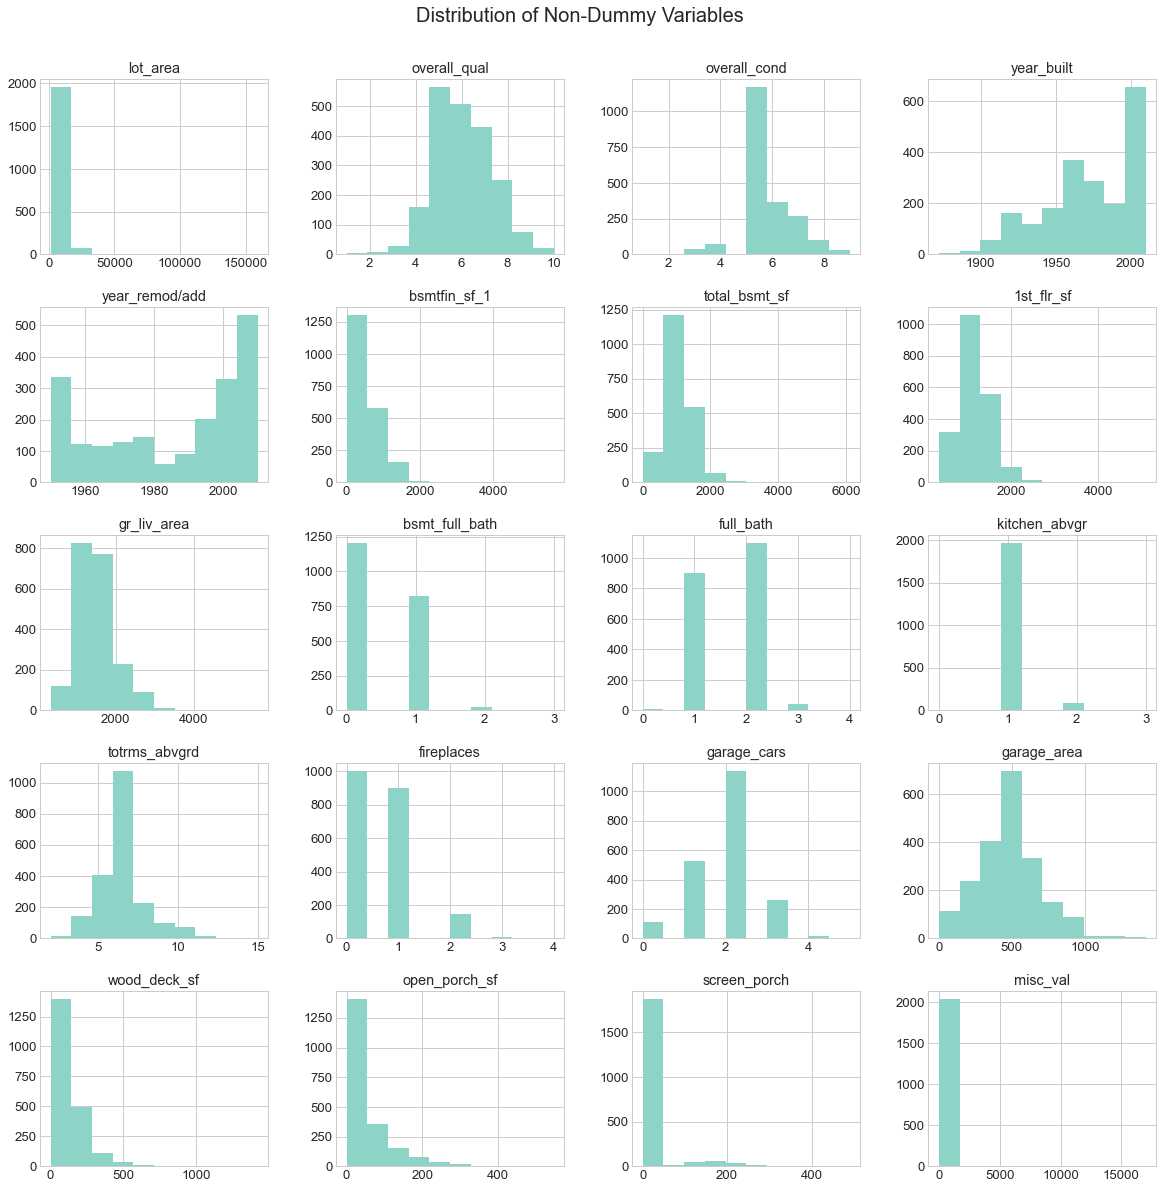

In [240]:
Xb.hist(column=non_dummy, figsize=(20,20))
plt.suptitle('Distribution of Non-Dummy Variables', y=0.93, fontsize=20)
plt.savefig('../images/non_dummy_before.png', bbox_inches='tight', facecolor='w')
plt.show()
# Many area variables seem to be right skewed. However, they have value 0 so a log transformation would result in an undefined value. From the literature, there are various ways of dealing with this e.g. log(X+1) or do a Box-Cox 2-parameter transformation (one for the exponent and one for the translation). To learn more about Box-Cox transformations and see their effect, I will attempt the latter with translation=1 so that 0 values are mapped back to 0. 

In [241]:
Xc = Xb.copy()
yc = yb.copy()

In [242]:
X_train, X_test, y_train, y_test = train_test_split(Xc,yc,random_state=42)

In [243]:
# Define a function to apply Box-Cox power transformation
def bc_vars(cols):
    lambda_list=[]
    for i in cols:
        X_train.loc[:,i], fitted_lambda = stats.boxcox(X_train[i]+1)
        X_test.loc[:,i] = stats.boxcox(X_test[i]+1, fitted_lambda)
        lambda_list.append(fitted_lambda)
    return f'lambdas used: {lambda_list}'

In [244]:
# Applying the transformation to selected variables with a right skew
cols = ['lot_area', 'bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area', 'wood_deck_sf', 'open_porch_sf']
bc_vars(cols)

'lambdas used: [0.2458991316705682, 0.2220308070336062, 0.7192346932357431, -0.0576706263716698, -0.02368510169403102, -0.07261222924042862, 0.01335096664918652]'

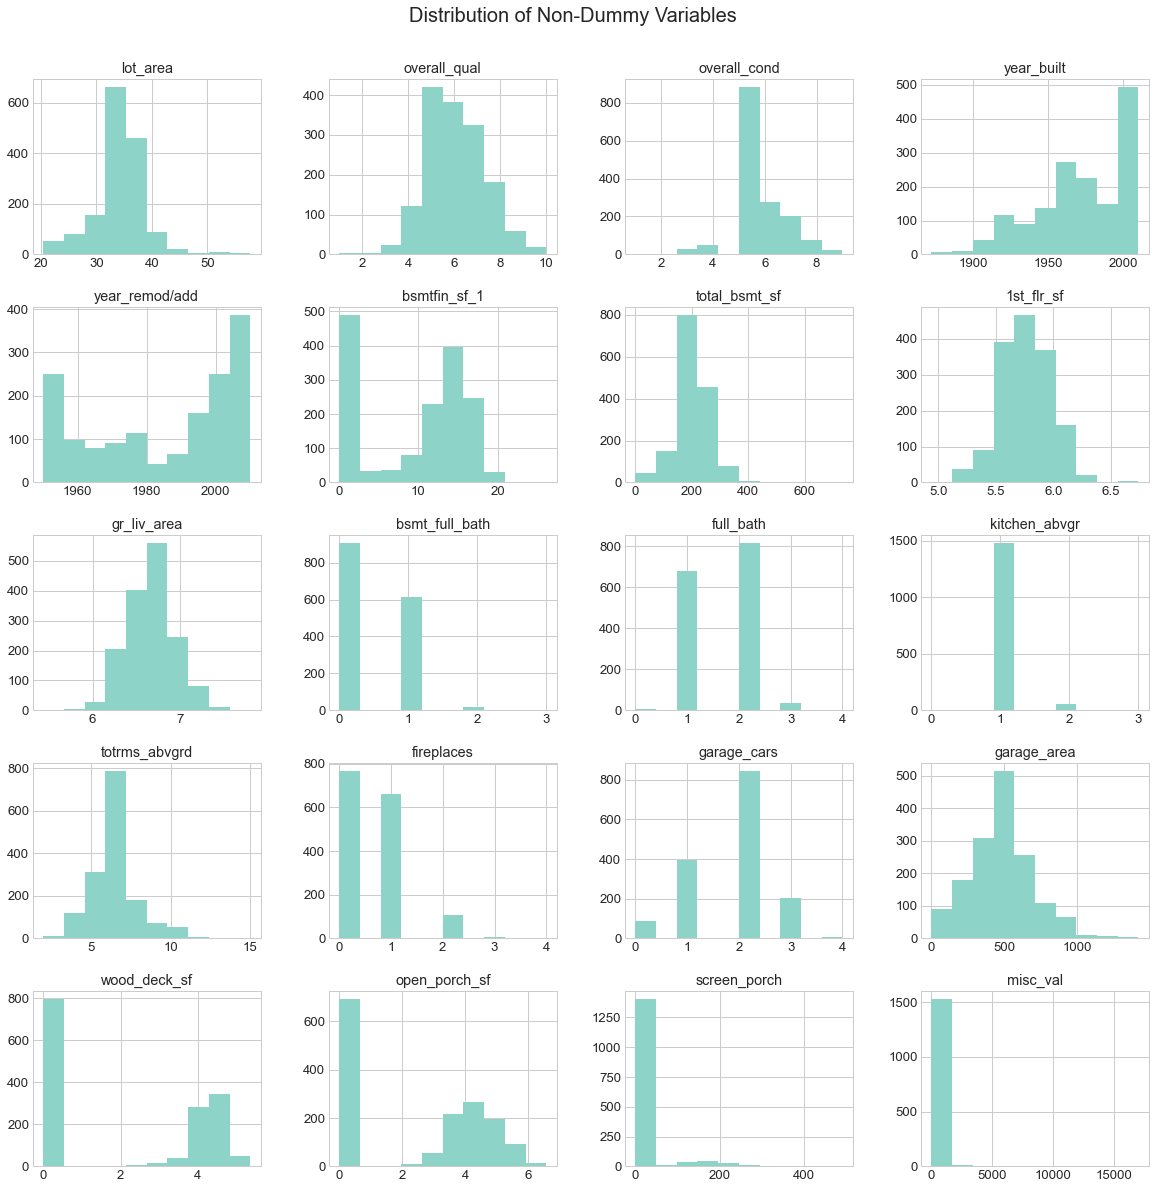

In [245]:
# The distribution of the variables seems to be more normal. However, some of these variables (e.g. wood_deck_sf) now have a large number of values at 0 apart from the main bulk of the distribution. This may reduce the explanatory power of those variables.
X_train.hist(column=non_dummy, figsize=(20,20))
plt.suptitle('Distribution of Non-Dummy Variables', y=0.93, fontsize=20)
plt.savefig('../images/non_dummy_after.png', bbox_inches='tight', facecolor='w')
plt.show()

In [246]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [247]:
lasso_cv_c = lasso_model.fit(Z_train, y_train)
print(f'Optimal alpha: {lasso_cv.alpha_}')
scores(lasso_cv_c, Z_train, y_train, Z_test, y_test)

Optimal alpha: 0.001
Train Score: 0.9359361744888912.
Test Score: 0.8941259592644089.
Cross Validation Score: 0.889454526916958.
RMSE on Test: 22111.8732276329.
MAE on Test: 14851.761709391672.


The method of applying a Box-Cox power transformation to improve the normality of variables has increased the train score and the test score by 0.01. One problem with using Box-Cox is that it may not be possible to interpret the regression coefficients easily, unlike the log transformation. However, as the problem statement emphasises prediction over interpretation, have chosen to try this for this project. Given more time, I could try log(x+1) to see if it has the same effect.

## Method D: Remove Outliers

In [248]:
# Investigating most highly correlated variables to see if outliers have a big influence
xtrain_d = pd.concat([X_train,y_train], axis=1)
corr_xtrain_d = xtrain_d.corr()[['logsaleprice']]
corr_xtrain_d['abs_corr'] = abs(corr_xtrain_d['logsaleprice'])
corr_xtrain_d.sort_values('abs_corr', ascending=False).head(6)

logsaleprice  abs_corr
logsaleprice      1.000000  1.000000
overall_qual      0.821850  0.821850
gr_liv_area       0.720807  0.720807
garage_cars       0.677561  0.677561
garage_area       0.651966  0.651966
year_built        0.618587  0.618587

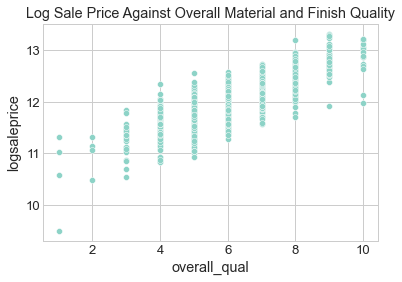

In [249]:
sns.scatterplot(data=xtrain_d, x='overall_qual', y='logsaleprice')
plt.title('Log Sale Price Against Overall Material and Finish Quality')
plt.show()

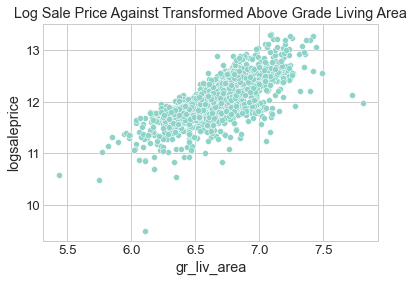

In [250]:
sns.scatterplot(data=xtrain_d, x='gr_liv_area', y='logsaleprice')
plt.title('Log Sale Price Against Transformed Above Grade Living Area')
plt.show()

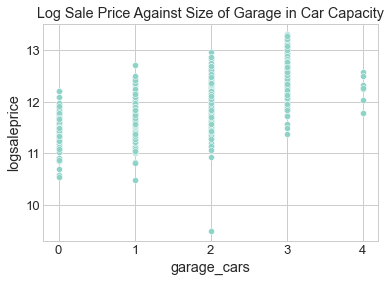

In [251]:
sns.scatterplot(data=xtrain_d, x='garage_cars', y='logsaleprice')
plt.title('Log Sale Price Against Size of Garage in Car Capacity')
plt.show()

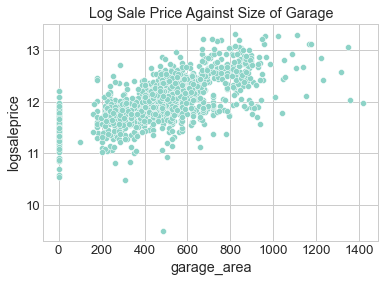

In [252]:
sns.scatterplot(data=xtrain_d, x='garage_area', y='logsaleprice')
plt.title('Log Sale Price Against Size of Garage')
plt.show()

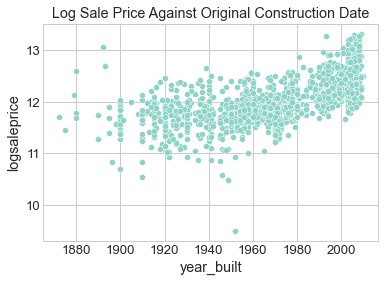

In [253]:
sns.scatterplot(data=xtrain_d, x='year_built', y='logsaleprice')
plt.title('Log Sale Price Against Original Construction Date')
plt.show()

In [254]:
# There is one point which has low logsaleprice that might be biasing the coefficient. I will remove this point.
y_train[y_train<10]

183    9.480368
Name: logsaleprice, dtype: float64

In [255]:
# There are two points with high transformed Above Grade Living Area more than 7.6 which does not fit the trend. I will also remove these points.
xtrain_d[xtrain_d['gr_liv_area']>7.6]

lot_area  overall_qual  overall_cond  year_built  year_remod/add  \
1885  50.757919            10             5        2008            2009   
960   57.719485            10             5        2008            2008   

      bsmtfin_sf_1  total_bsmt_sf  1st_flr_sf  gr_liv_area  bsmt_full_bath  \
1885     23.915845     643.517072    6.741284     7.728613             1.0   
960      26.156091     733.517132    6.690809     7.811808             2.0   

      full_bath  kitchen_abvgr  totrms_abvgrd  fireplaces  garage_cars  \
1885          2              1             15           2          3.0   
960           2              1             12           3          2.0   

      garage_area  wood_deck_sf  open_porch_sf  screen_porch  misc_val  \
1885       1154.0      5.058561       6.446618             0     17000   
960        1418.0      4.447261       5.901102             0         0   

      ms_subclass-30  ms_subclass-160  ms_zoning-C (all)  ms_zoning-RM  \
1885               0                0                  0             0   
960                0                0                  0             0   

      street-Pave  lot_shape-IR3  land_contour-HLS  lot_config-CulDSac  \
1885            1              0                 0                   0   
960             1              1                 0                   0   

      neighborhood-ClearCr  neighborhood-Crawfor  neighborhood-Edwards  \
1885                     0                     0                     1   
960                      0                     0                     1   

      neighborhood-GrnHill  neighborhood-MeadowV  neighborhood-NoRidge  \
1885                     0                     0                     0   
960                      0                     0                     0   

      neighborhood-NridgHt  neighborhood-OldTown  neighborhood-SawyerW  \
1885                     0                     0                     0   
960                      0                     0                     0   

      neighborhood-Somerst  neighborhood-StoneBr  neighborhood-Timber  \
1885                     0                     0                    0   
960                      0                     0                    0   

      condition_1-Norm  condition_1-PosN  condition_2-PosA  bldg_type-Twnhs  \
1885                 1                 0                 0                0   
960                  0                 0                 0                0   

      bldg_type-TwnhsE  roof_style-Hip  roof_style-Mansard  roof_matl-WdShngl  \
1885                 0               1                   0                  0   
960                  0               1                   0                  0   

      exterior_1st-BrkComm  exterior_1st-BrkFace  exterior_1st-Stucco  \
1885                     0                     0                    0   
960                      0                     0                    1   

      exterior_2nd-MetalSd  exterior_2nd-Stucco  exter_qual-Fa  exter_qual-TA  \
1885                     0                    0              0              0   
960                      0                    1              0              0   

      exter_cond-Po  foundation-PConc  foundation-Slab  bsmt_qual-NA  \
1885              0                 1                0             0   
960               0                 1                0             0   

      bsmt_cond-Fa  bsmt_cond-NA  bsmt_exposure-Gd  bsmt_exposure-NA  \
1885             0             0                 1                 0   
960              0             0                 1                 0   

      bsmt_exposure-No  bsmtfin_type_1-GLQ  bsmtfin_type_1-NA  \
1885                 0                   1                  0   
960                  0                   1                  0   

      bsmtfin_type_1-Unf  bsmtfin_type_2-NA  heating-Grav  heating-Wall  \
1885                   0                  0             0             0   
960                    0               

In [256]:
# Defining Box-Cox function proper
def bc_vars_final(train, test, cols): 
    for i in cols:
        train.loc[:, f'bc_{i}'], fitted_lambda = stats.boxcox(train[i]+1)
        test.loc[:, f'bc_{i}'] = stats.boxcox(test[i]+1, lmbda=fitted_lambda)
        train.drop(columns=i, inplace=True)
        test.drop(columns=i, inplace=True)

In [257]:
# Remodelling with these outliers removed
pd.options.mode.chained_assignment = None

Xd = Xc.copy()
yd = yc.copy()

X_train, X_test, y_train, y_test = train_test_split(Xd,yd,random_state=42)

X_train.drop([183,960,1885], inplace=True)
y_train.drop([183,960,1885], inplace=True)

cols = ['lot_area', 'bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area', 'wood_deck_sf', 'open_porch_sf']
bc_vars_final(X_train, X_test, cols)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

lasso_cv_d = lasso_model.fit(Z_train, y_train)
print(f'Optimal alpha: {lasso_cv.alpha_}')
scores(lasso_cv_d, Z_train, y_train, Z_test, y_test)

Optimal alpha: 0.001
Train Score: 0.9433116020777992.
Test Score: 0.9020422230230635.
Cross Validation Score: 0.9285879226355807.
RMSE on Test: 20713.85256755067.
MAE on Test: 14293.196528682964.


Removing outliers has increased the train and test scores by another 0.01, preventing them from biasing our model.

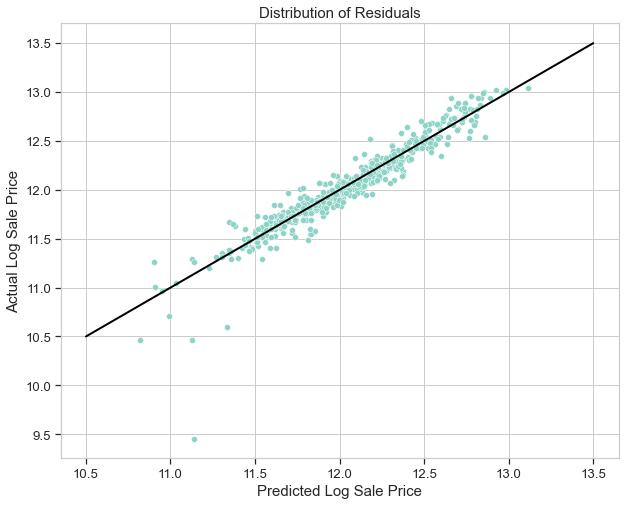

In [258]:
# Errors appear to be homoskedastic except at low sale prices where there are few data points
sns.set_context('notebook', font_scale=1.2)
preds = lasso_cv_d.predict(Z_test)
plt.figure(figsize=(10,8))
g = sns.scatterplot(x=preds,y=y_test)
plt.xlabel('Predicted Log Sale Price', fontsize=15)
plt.ylabel('Actual Log Sale Price', fontsize=15)
plt.title('Distribution of Residuals', fontsize=15)
plt.plot((10.5,13.5), (10.5,13.5), color='k', linewidth=2)
plt.savefig('../images/predicted_against_actual.png', bbox_inches='tight', facecolor='w')
plt.show()

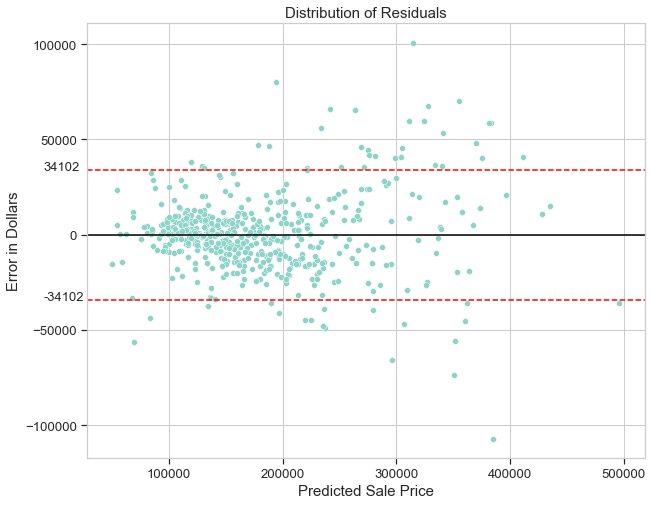

In [259]:
# Our model is able to correctly predict 90% of actual sales prices within an error of $34,102.
preds = lasso_cv_d.predict(Z_test)
plt.figure(figsize=(10,8))
p90 = np.percentile(abs(np.exp(y_test)-np.exp(preds)), 90)
g = sns.scatterplot(x=np.exp(preds),y=np.exp(y_test)-np.exp(preds))
plt.xlabel('Predicted Sale Price', fontsize=15)
plt.ylabel('Error in Dollars', fontsize=15)
g.axhline(y=0, color='k')
g.axhline(y=p90, color='r', linestyle='--')
g.axhline(y=-p90, color='r', linestyle='--')
g.text(x=-10000, y=p90, s=f'{round(p90)}', fontsize=13)
g.text(x=-10000, y=-p90, s=f'{round(-p90)}', fontsize=13)
plt.title('Distribution of Residuals', fontsize=15)
plt.savefig('../images/predicted_vs_error.png', bbox_inches='tight', facecolor='w')
plt.show()

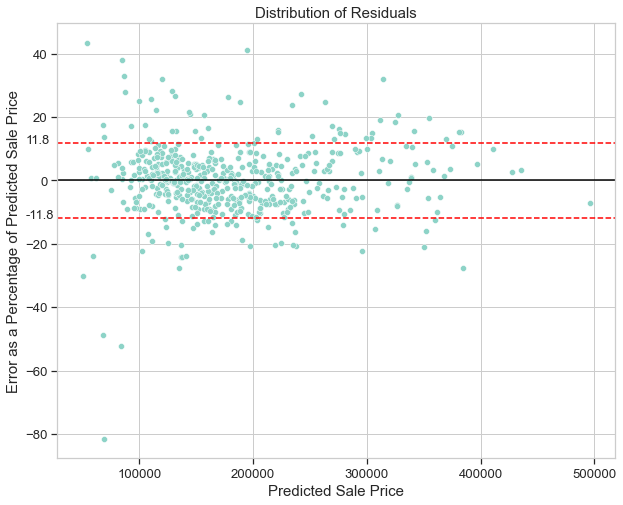

In [260]:
# Our model is able to correctly predict 90% of actual sales prices within an error of 11.8% of predicted sale price.
preds = lasso_cv_d.predict(Z_test)
plt.figure(figsize=(10,8))
p90 = np.percentile((np.exp(y_test)-np.exp(preds))/np.exp(preds), 90)*100
g = sns.scatterplot(x=np.exp(preds),y=(np.exp(y_test)-np.exp(preds))/np.exp(preds)*100)
plt.xlabel('Predicted Sale Price', fontsize=15)
plt.ylabel('Error as a Percentage of Predicted Sale Price', fontsize=15)
plt.title('Distribution of Residuals', fontsize=15)
g.axhline(y=0, color='k')
g.axhline(y=p90, color='r', linestyle='--')
g.axhline(y=-p90, color='r', linestyle='--')
g.text(x=0, y=p90, s=f'{round(p90, 1)}', fontsize=13)
g.text(x=0, y=-p90, s=f'{round(-p90, 1)}', fontsize=13)
plt.savefig('../images/predicted_vs_percenterror.png', bbox_inches='tight', facecolor='w')
plt.show()

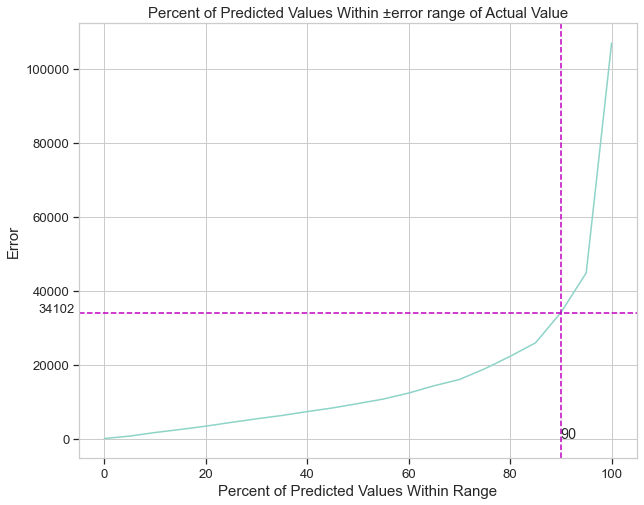

In [261]:
a = list(range(0,101,5))
b = np.percentile(abs(np.exp(y_test)-np.exp(preds)), a)
p90 = np.percentile(abs(np.exp(y_test)-np.exp(preds)), 90)
plt.figure(figsize=(10,8))
g = sns.lineplot(x=a,y=b)
plt.xlabel('Percent of Predicted Values Within Range', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Percent of Predicted Values Within \u00B1error range of Actual Value', fontsize=15)
g.axvline(x=90, color='m', linestyle='--')
g.axhline(y=p90, color='m', linestyle='--')
g.text(x=-13, y=p90, s=f'{round(p90)}', fontsize=13)
g.text(x=90, y=0, s='90')
plt.savefig('../images/error_growth.png', bbox_inches='tight', facecolor='w')
plt.show()

Our model is reasonably accurate, predicting 90% of values correctly within an error of $34,102 or 11.8% of the predicted sale price. Nevertheless, the model gets more inaccurate in dollar terms as predicted sale price increases, which entails that we may need more data for more expensive homes to further refine our model. 

In [262]:
# Surprisingly, Linear Regression on the unstandardised X_train performs quite well too, with only a slightly higher RMSE and MAE compared to Lasso.
lr = LinearRegression()
lr.fit(X_train, y_train)
scores(lr, X_train, y_train, X_test, y_test)

Train Score: 0.9437757480802297.
Test Score: 0.9006367791729987.
Cross Validation Score: 0.9280179321443853.
RMSE on Test: 20925.517828520668.
MAE on Test: 14398.374878435912.


## Applying Methods and Modelling on Full Train Set

In [263]:
# Checking outliers
X_final = X.copy()
y_final = y.copy()

train_d = pd.concat([X_final,y_final], axis=1)
corr_train_d = train_d.corr()[['logsaleprice']]
corr_train_d['abs_corr'] = abs(corr_train_d['logsaleprice'])
corr_train_d.sort_values('abs_corr', ascending=False).head(6)

logsaleprice  abs_corr
logsaleprice      1.000000  1.000000
overall_qual      0.822774  0.822774
gr_liv_area       0.687774  0.687774
garage_cars       0.667168  0.667168
garage_area       0.650243  0.650243
year_built        0.624449  0.624449

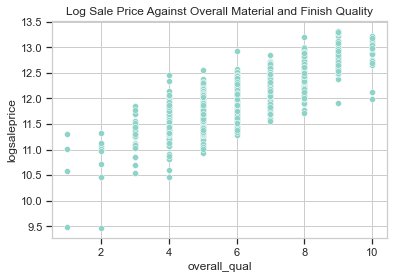

In [264]:
sns.set_context('notebook', font_scale=1)
sns.scatterplot(data=train_d, x='overall_qual', y='logsaleprice')
plt.title('Log Sale Price Against Overall Material and Finish Quality')
plt.show()

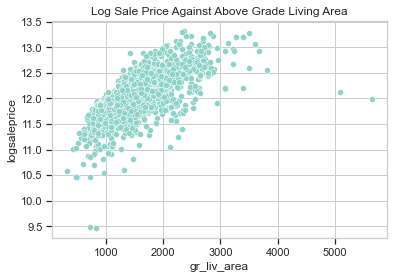

In [265]:
sns.scatterplot(data=train_d, x='gr_liv_area', y='logsaleprice')
plt.title('Log Sale Price Against Above Grade Living Area')
plt.savefig('../images/living_area_outlier.png', bbox_inches='tight', facecolor='w')
plt.show()

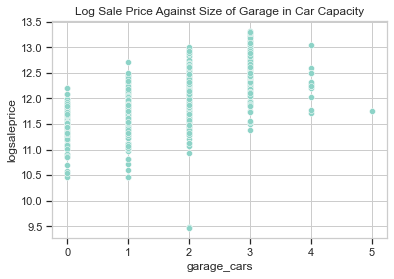

In [266]:
sns.scatterplot(data=train_d, x='garage_cars', y='logsaleprice')
plt.title('Log Sale Price Against Size of Garage in Car Capacity')
plt.show()

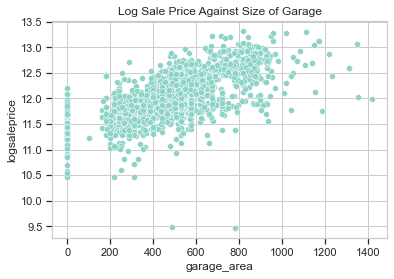

In [267]:
sns.scatterplot(data=train_d, x='garage_area', y='logsaleprice')
plt.title('Log Sale Price Against Size of Garage')
plt.show()

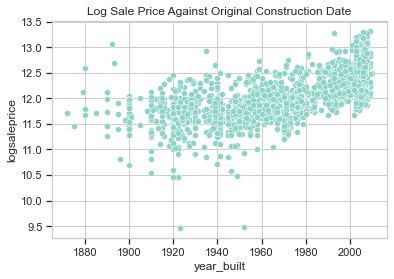

In [268]:
sns.scatterplot(data=train_d, x='year_built', y='logsaleprice')
plt.title('Log Sale Price Against Original Construction Date')
plt.show()

In [269]:
# There are two points which have low logsaleprice that might be biasing the relationships. 
y_final[y_final<10]

183     9.480368
1628    9.456341
Name: logsaleprice, dtype: float64

In [270]:
# There are also two points with high Above Grade Living Area more than 5000sqft which do not fit the trend.
X_final[X_final['gr_liv_area']>5000]

id        pid  lot_frontage  lot_area  overall_qual  overall_cond  \
960   1499  908154235         313.0     63887            10             5   
1885  2181  908154195         128.0     39290            10             5   

      year_built  year_remod/add  mas_vnr_area  bsmtfin_sf_1  bsmtfin_sf_2  \
960         2008            2008         796.0        5644.0           0.0   
1885        2008            2009        1224.0        4010.0           0.0   

      bsmt_unf_sf  total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  \
960         466.0         6110.0        4692         950                0   
1885       1085.0         5095.0        5095           0                0   

      gr_liv_area  bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  \
960          5642             2.0             0.0          2          1   
1885         5095             1.0             1.0          2          1   

      bedroom_abvgr  kitchen_abvgr  totrms_abvgrd  fireplaces  garage_yr_blt  \
960               3              1             12           3         2008.0   
1885              2              1             15           2         2008.0   

      garage_cars  garage_area  wood_deck_sf  open_porch_sf  enclosed_porch  \
960           2.0       1418.0           214            292               0   
1885          3.0       1154.0           546            484               0   

      3ssn_porch  screen_porch  pool_area  misc_val  ms_subclass-30  \
960            0             0        480         0               0   
1885           0             0          0     17000               0   

      ms_subclass-40  ms_subclass-45  ms_subclass-50  ms_subclass-60  \
960                0               0               0               1   
1885               0               0               0               0   

      ms_subclass-70  ms_subclass-75  ms_subclass-80  ms_subclass-85  \
960                0               0               0               0   
1885               0               0               0               0   

      ms_subclass-90  ms_subclass-120  ms_subclass-150  ms_subclass-160  \
960                0                0                0                0   
1885               0                0                0                0   

      ms_subclass-180  ms_subclass-190  ms_zoning-C (all)  ms_zoning-FV  \
960                 0                0                  0             0   
1885                0                0                  0             0   

      ms_zoning-I (all)  ms_zoning-RH  ms_zoning-RL  ms_zoning-RM  \
960                   0             0             1             0   
1885                  0             0             1             0   

      street-Pave  alley-NA  alley-Pave  lot_shape-IR2  lot_shape-IR3  \
960             1         1           0              0              1   
1885            1         1           0              0              0   

      lot_shape-Reg  land_contour-HLS  land_contour-Low  land_contour-Lvl  \
960               0                 0                 0                 0   
1885              0                 0                 0                 0   

      utilities-NoSeWa  utilities-NoSewr  lot_config-CulDSac  lot_config-FR2  \
960                  0                 0                   0               0   
1885                 0                 0                   0               0   

      lot_config-FR3  lot_config-Inside  land_slope-Mod  land_slope-Sev  \
960                0                  0               0               0   
1885               0                  1               0               0   

      neighborhood-Blueste  neighborhood-BrDale  neighborhood-BrkSide  \
960                      0                    0                     0   
1885                     0                    0                     0   

      neighborhood-ClearCr  neighborhood-CollgCr  neighborhood-Crawfor  \
960                      0                     0                     0   
1885     

In [271]:
# Training on full train set
X_final = X.copy()
y_final = y.copy()
test_final = test.copy()

X_final.drop([183,1628,960,1885], inplace=True)
y_final.drop([183,1628,960,1885], inplace=True)

X_final.drop(columns=null_coefs, inplace=True)
y_final.drop(columns=null_coefs, inplace=True)
test_final.drop(columns=null_coefs, inplace=True)

cols = ['lot_area', 'bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area', 'wood_deck_sf', 'open_porch_sf']
bc_vars_final(X_final, test_final, cols)

sc = StandardScaler()
Z_final = sc.fit_transform(X_final)
Z_test_final = sc.transform(test_final)

lasso_cv_final = lasso_model.fit(Z_final, y_final)

print(f'Optimal alpha: {lasso_cv.alpha_}')
print(f'Train Score: {lasso_cv.score(Z_final, y_final)}.')

# Generating final predictions for Kaggle
pred_model_final = np.exp(lasso_cv_final.predict(Z_test_final))
df_final = test[['id']].copy()
df_final['SalePrice'] = pred_model_final
df_final.to_csv('../predictions/final.csv', index=False)

Optimal alpha: 0.0015199110829529332
Train Score: 0.9401179703552559.


## Examining Final Model

In [272]:
# Checking out Lasso coefficients. In the final model, above grade living area, overall quality, original construction date, overall condition and lot area are the most important variables. For categorical variables, being in Northridge Neighborhood and not having a commercial zoning appear to have the greatest effect. 
lasso_coefs = pd.DataFrame({'variable':X_final.columns,
                            'coef':lasso_cv_final.coef_,
                            'abs_coef':np.abs(lasso_cv_final.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(11)

variable      coef  abs_coef
90        bc_gr_liv_area  0.121887  0.121887
0           overall_qual  0.078810  0.078810
2             year_built  0.060075  0.060075
1           overall_cond  0.043756  0.043756
86           bc_lot_area  0.040172  0.040172
88      bc_total_bsmt_sf  0.034140  0.034140
87       bc_bsmtfin_sf_1  0.029439  0.029439
27  neighborhood-NridgHt  0.021990  0.021990
3         year_remod/add  0.021198  0.021198
10           garage_area  0.019932  0.019932
15     ms_zoning-C (all) -0.019186  0.019186

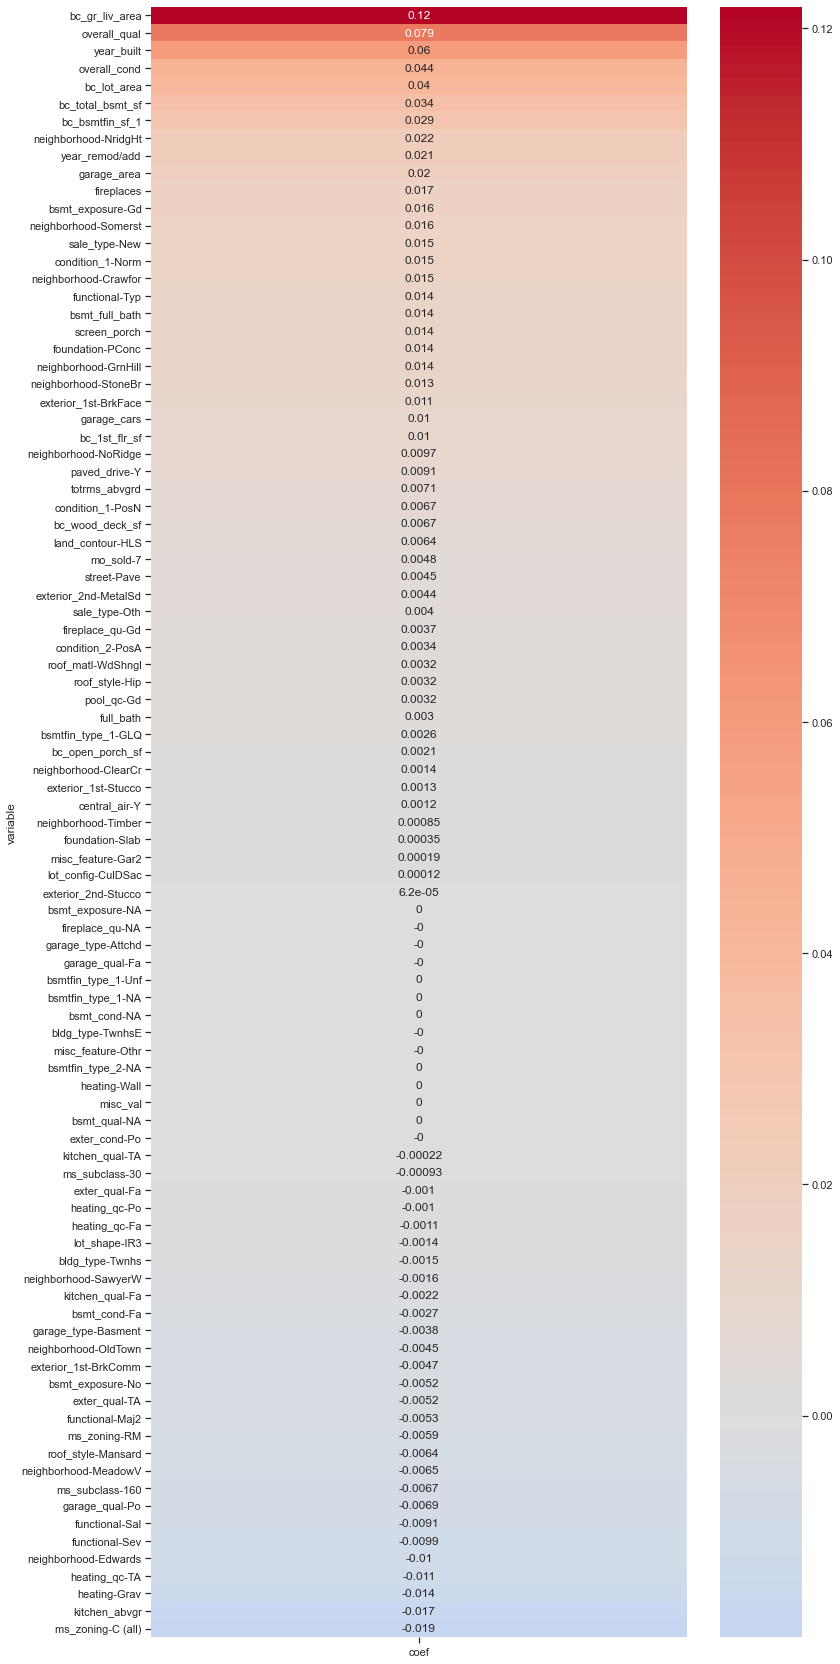

In [273]:
# Some more coefficients went to 0 this time round
lasso_coefs.sort_values('coef', inplace=True, ascending=False)
coefs = lasso_coefs.set_index('variable').drop(columns='abs_coef')
fig = plt.figure(figsize=(12,30))
sns.heatmap(coefs,annot=True, cmap='coolwarm', center=0)
plt.show()

In [274]:
# Checking out OLS model using Statsmodel
X_final = X.copy()
y_final = y.copy()
test_final = test.copy()

X_final.drop([183,1628,960,1885], inplace=True)
y_final.drop([183,1628,960,1885], inplace=True)

X_final.drop(columns=null_coefs, inplace=True)
y_final.drop(columns=null_coefs, inplace=True)
test_final.drop(columns=null_coefs, inplace=True)

cols = ['lot_area', 'bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area', 'wood_deck_sf', 'open_porch_sf']
bc_vars_final(X_final, test_final, cols)

X_final = sm.add_constant(X_final)
ols = sm.OLS(y_final, X_final).fit()

In [275]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           logsaleprice   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     350.8
Date:                Thu, 08 Apr 2021   Prob (F-statistic):               0.00
Time:                        18:31:59   Log-Likelihood:                 1848.9
No. Observations:                2047   AIC:                            -3518.
Df Residuals:                    1957   BIC:                            -3012.
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.3513      0.476      4.937      0.000       1.417       3.285
overall_qual             0.0518      0.003     15.602      0.000       0.045       0.058
overall_cond             0.0410      0.003     14.452      0.000       0.035       0.047
year_built               0.0020      0.000     10.448      0.000       0.002       0.002
year_remod/add           0.0010      0.000      5.256      0.000       0.001       0.001
bsmt_full_bath           0.0269      0.006      4.446      0.000       0.015       0.039
full_bath                0.0088      0.006      1.376      0.169      -0.004       0.021
kitchen_abvgr           -0.0967      0.014     -7.113      0.000      -0.123      -0.070
totrms_abvgrd            0.0057      0.003      2.011      0.044       0.000       0.011
fireplaces               0.0282      0.009      3.115      0.002       0.010       0.046
garage_cars              0.0146      0.007      1.965      0.050    2.56e-05       0.029
garage_area           8.429e-05    2.6e-05      3.246      0.001    3.34e-05       0.000
screen_porch             0.0003   4.11e-05      6.621      0.000       0.000       0.000
misc_val             -1.492e-06   8.84e-06     -0.169      0.866   -1.88e-05    1.58e-05
ms_subclass-30          -0.0123      0.013     -0.962      0.336      -0.037       0.013
ms_subclass-160         -0.0375      0.017     -2.187      0.029      -0.071      -0.004
ms_zoning-C (all)       -0.2165      0.026     -8.340      0.000      -0.267      -0.166
ms_zoning-RM            -0.0134      0.009     -1.467      0.143      -0.031       0.005
street-Pave              0.0919      0.041      2.237      0.025       0.011       0.173
lot_shape-IR3           -0.0405      0.036     -1.113      0.266      -0.112       0.031
land_contour-HLS         0.0333      0.013      2.557      0.011       0.008       0.059
lot_config-CulDSac       0.0061      0.010      0.634      0.526      -0.013       0.025
neighborhood-ClearCr     0.0271      0.021      1.289      0.197      -0.014       0.068
neighborhood-Crawfor     0.0891      0.014      6.330      0.000       0.062       0.117
neighborhood-Edwards    -0.0486      0.010     -4.943      0.000      -0.068      -0.029
neighborhood-GrnHill     0.4920      0.074      6.658      0.000       0.347       0.637
neighborhood-MeadowV    -0.0728      0.024     -3.042      0.002      -0.120      -0.026
neighborhood-NoRidge     0.0771      0.017      4.636      0.000       0.044       0.110
neighborhood-NridgHt     0.1060      0.012      8.548      0.000       0.082       0.130
neighborhood-OldTown    -0.0278      0.012     -2.368      0.018      -0.051      -0.005
neighborhood-SawyerW    -0.0117      0.012     -0.985      0.325      -0.035       0.012
neighborhood-Somerst     0.0767      0.012      6.643    

The model did well in the Kaggle competition, with public and private scores (determined by RMSE) of 23206 and 18394 respectively, which is 12th and 3rd out of 89 on the respective leaderboards. 

The method to use LassoCV to do feature selection worked well at getting the OLS model to a place of low bias and low variance (adjusted r-squared of 0.938) Nevertheless, there are some coefficients in the OLS model which are not statistically significant. Given more time, I would try to remove these variables and rerun Lasso to see if I can reduce variance further without increasing bias. 
